In [1]:
import tensorflow as tf
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import PIL.Image
import random

In [2]:
filter_size_1 = 5
filter_num_1 = 16
filter_size_2 = 5
filter_num_2 = 36
fc_size = 128


In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [5]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [6]:
data.train.images.shape


(55000, 784)

In [7]:
data.train.images[0].shape

(784,)

In [8]:
img_size = 28
num_channels = 1
img_size_flat = img_size * img_size 
img_shape = (img_size, img_size,)
num_classes = 10

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

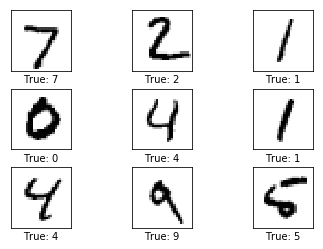

In [10]:
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]


# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [50]:
img_shape

(28, 28)

In [11]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [12]:
def new_biases(length):
    #equivalent to y intercept
    #constant value carried over across matrix math
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [14]:
def new_con_layer(input,number_input_channel,filter_size,number_of_filters,use_pooling= True):
    
    shape = [filter_size, filter_size, number_input_channel, number_of_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=number_of_filters)
    layer = tf.nn.conv2d(input=input,filter=weights,strides=[1,1,1,1],padding='SAME')
    
    if use_pooling:
        layer = tf.nn.max_pool(layer,strides=[1,2,2,1],ksize=[1,2,2,1],padding='SAME')
        
    layer = tf.nn.relu(layer)
    return layer,weights

    
    

In [15]:
def flatten_layer(input):
    input_shape = input.shape
    num_features = input_shape[1:4].num_elements()
    layer_flat = tf.reshape(input, [-1, num_features])
    return layer_flat,num_features


In [16]:
def fully_connected_layer(input,num_of_input,num_of_output,use_relu =True):
    
    weights = new_weights(shape=[num_of_input, num_of_output])
    biases = new_biases(length=num_of_output)
    layer = tf.matmul(input,weights)+biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer
                
    

In [17]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)


In [18]:
layer_conv1, weights_conv1 = \
    new_con_layer(input=x_image,
                   number_input_channel=num_channels,
                   filter_size=filter_size_1,
                   number_of_filters=filter_num_1,
                   use_pooling=True)
    

In [19]:
layer_conv1


<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [20]:
layer_conv2, weights_conv2 = \
    new_con_layer(input=layer_conv1,
                   number_input_channel=filter_num_1,
                   filter_size=filter_size_2,
                   number_of_filters=filter_num_2,
                   use_pooling=True)

In [21]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [22]:
layer_flatten,number_of_features = flatten_layer(layer_conv2)

In [23]:
print(layer_flatten)
print(number_of_features)

Tensor("Reshape_1:0", shape=(?, 1764), dtype=float32)
1764


In [24]:
layer_fc1 = fully_connected_layer(layer_flatten,number_of_features,fc_size)

In [25]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [26]:
layer_fc2 = fully_connected_layer(layer_fc1,fc_size,num_classes,use_relu=False)

In [27]:
layer_fc2

<tf.Tensor 'add_1:0' shape=(?, 10) dtype=float32>

In [28]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [29]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

In [30]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

In [31]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [32]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [33]:
train_batch_size = 64


In [39]:
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [40]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [36]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [41]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [38]:
print_test_accuracy()

Accuracy on Test-Set: 9.4% (940 / 10000)


In [42]:
optimize(num_iterations=1)


Optimization Iteration:      1, Training Accuracy:  14.1%
Time usage: 0:00:00


In [43]:
print_test_accuracy()

Accuracy on Test-Set: 9.7% (974 / 10000)


In [44]:
optimize(num_iterations=99) # We already performed 1 iteration above.


Time usage: 0:00:04


Accuracy on Test-Set: 94.3% (9430 / 10000)
Example errors:


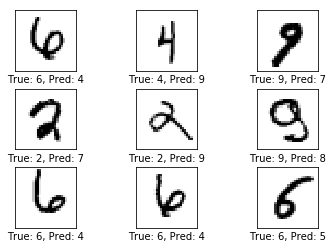

In [45]:
print_test_accuracy(show_example_errors=True)


In [46]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    101, Training Accuracy:  96.9%
Optimization Iteration:    201, Training Accuracy:  93.8%
Optimization Iteration:    301, Training Accuracy:  96.9%
Optimization Iteration:    401, Training Accuracy:  96.9%
Optimization Iteration:    501, Training Accuracy:  95.3%
Optimization Iteration:    601, Training Accuracy:  98.4%
Optimization Iteration:    701, Training Accuracy:  96.9%
Optimization Iteration:    801, Training Accuracy:  98.4%
Optimization Iteration:    901, Training Accuracy: 100.0%
Time usage: 0:00:36


Accuracy on Test-Set: 98.0% (9804 / 10000)
Example errors:


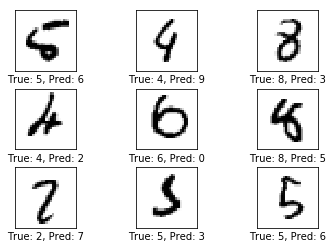

In [47]:
print_test_accuracy(show_example_errors=True)

In [48]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1001, Training Accuracy: 100.0%
Optimization Iteration:   1101, Training Accuracy:  98.4%
Optimization Iteration:   1201, Training Accuracy: 100.0%
Optimization Iteration:   1301, Training Accuracy:  98.4%
Optimization Iteration:   1401, Training Accuracy: 100.0%
Optimization Iteration:   1501, Training Accuracy:  96.9%
Optimization Iteration:   1601, Training Accuracy:  98.4%
Optimization Iteration:   1701, Training Accuracy: 100.0%
Optimization Iteration:   1801, Training Accuracy:  98.4%
Optimization Iteration:   1901, Training Accuracy:  98.4%
Optimization Iteration:   2001, Training Accuracy: 100.0%
Optimization Iteration:   2101, Training Accuracy: 100.0%
Optimization Iteration:   2201, Training Accuracy:  98.4%
Optimization Iteration:   2301, Training Accuracy:  98.4%
Optimization Iteration:   2401, Training Accuracy: 100.0%
Optimization Iteration:   2501, Training Accuracy: 100.0%
Optimization Iteration:   2601, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 97.9% (9788 / 10000)
Example errors:


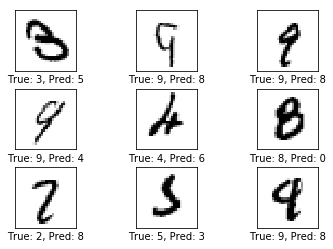

Confusion Matrix:
[[ 974    0    0    0    0    0    4    1    0    1]
 [   3 1110    4    1    0    0    3    2   12    0]
 [   5    1 1013    2    0    0    0    1    9    1]
 [   1    0    4  998    0    1    0    2    3    1]
 [   1    0    0    0  960    0    4    1    6   10]
 [   0    0    1   10    0  876    4    0    1    0]
 [   4    2    3    1    3    5  938    0    2    0]
 [   0    1    8    1    4    0    0 1008    4    2]
 [   6    0    1    4    0    4    1    2  955    1]
 [   1    4    0    4   15    2    0    3   24  956]]


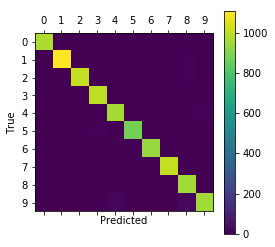

In [49]:
print_test_accuracy(show_confusion_matrix=True,show_example_errors=True)